<a href="https://colab.research.google.com/github/mehmetdamkaci/Monophonic_Pitch_Detection/blob/main/TinySOL_pitchDetection_cqt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://zenodo.org/record/3685331/files/TinySOL.tar.gz

--2023-04-14 13:05:03--  https://zenodo.org/record/3685331/files/TinySOL.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... ^C


In [ ]:
!gunzip < TinySOL.tar.gz | tar xvf -

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
csvDataset=pd.read_csv('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/TinySOL_metadata.csv')

csvInstrument=csvDataset[['Instrument (in full)','Pitch']]
Pitchs=csvDataset['Pitch'].unique()
Instruments=csvDataset['Instrument (in full)'].unique()
csvInstrument.loc[(csvInstrument['Pitch']==Pitchs[0]) & (csvInstrument['Instrument (in full)']==Instruments[0])]

liste=list()
for instrument in Instruments:
  liste.append([len(csvInstrument.loc[(csvInstrument['Pitch']==pitch) & (csvInstrument['Instrument (in full)']==instrument)]) for pitch in Pitchs])
pitchTable=pd.DataFrame(liste, index=Instruments, columns=Pitchs)

liste=pitchTable.columns
num_list=list()
for i in liste:
  num_list.append(len(pitchTable.loc[pitchTable[i]!=0]))

pitchDistr=pd.DataFrame(num_list, columns=['Num_Instrument'], index=liste)

delpitch=list()
pitchSelect=list()
pitchIDSelect=list()
pitchClass=pitchDistr.loc[pitchDistr['Num_Instrument']>1].index
for pitch in pitchClass:
  if len(csvDataset.loc[(csvDataset['Pitch']==pitch)])>=10:
    pitchSelect.append(pitch)
    pitchIDSelect.append(csvDataset.loc[(csvDataset['Pitch']==pitch)]['Pitch ID'].iloc[0])
  else:
    delpitch.append(pitch)
print(f'Length Of pitchSelect : {len(pitchSelect)}')
print(f'Length Of pitchIDSelect : {len(pitchIDSelect)}')

Mounted at /content/gdrive
Length Of pitchSelect : 71
Length Of pitchIDSelect : 71


In [ ]:
import librosa
import numpy as np

data=librosa.load('/content/TinySOL2020/'+csvDataset['Path'][92], sr=16000)[0]
cqtData=librosa.cqt(data, sr=16000, n_bins=90, hop_length=256,bins_per_octave=12)
cqtData=np.log(abs(cqtData)+ 1e-16)
cqtData.shape

In [ ]:
newFrame=csvDataset.loc[csvDataset['Pitch'].isin(pitchSelect)]

In [ ]:
import numpy as np
import librosa
from tqdm import tqdm
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import random

numOfRow=90
numOfColumn=83

numClass=len(pitchIDSelect)
def oneHotEnc(number):
  label=np.zeros((numClass), dtype=np.uint8)
  label[number-min(pitchIDSelect)]=1
  return label

def setData(Data, Label, pathList, pitchIDList):
  pbar=tqdm(total=len(pathList))
  filePath='/content/TinySOL2020/'
  for index, (path, note) in enumerate(zip(pathList,pitchIDList)):
    data=librosa.load(filePath+path, sr=16000)[0]
    cqtWav=librosa.cqt(data, sr=16000, n_bins=90, hop_length=256,bins_per_octave=12)
    Data[index]=np.log10(np.abs(cqtWav[:,:numOfColumn]))
    Label[index]=oneHotEnc(note)  
    pbar.update(1)
  pbar.close()
  return Data, Label

# Verileri görselleştirir.
def drawSpec(data, label):

  plt.figure(figsize=(25,10))
  for i in range(8):
    index=random.randint(0,len(data))
    plt.subplot(2, 4, i+1)
    librosa.display.specshow(data[index].reshape(numOfRow,numOfColumn), sr=16000, 
                             hop_length=2048//4, x_axis='s', y_axis='hz', cmap='viridis')
    plt.title(np.where(label[index]==1)[0][0])
  plt.show()

In [ ]:
trainPath=newFrame['Path']
pitchIDList=newFrame['Pitch ID']
trainData=np.zeros((len(trainPath), numOfRow, numOfColumn), dtype=np.float32)
trainLabel=np.zeros((len(trainPath),numClass), dtype=np.uint8)

trainData, trainLabel=setData(trainData, trainLabel, trainPath, pitchIDList)
print(f'\nShape Of Train Data : {trainData.shape}')
print(f'Shape Of Train Label : {trainLabel.shape}')

np.save('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/trainData16_71Class_cqt.npy', trainData)
np.save('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/trainLabel16_71Class_cqt.npy', trainLabel)

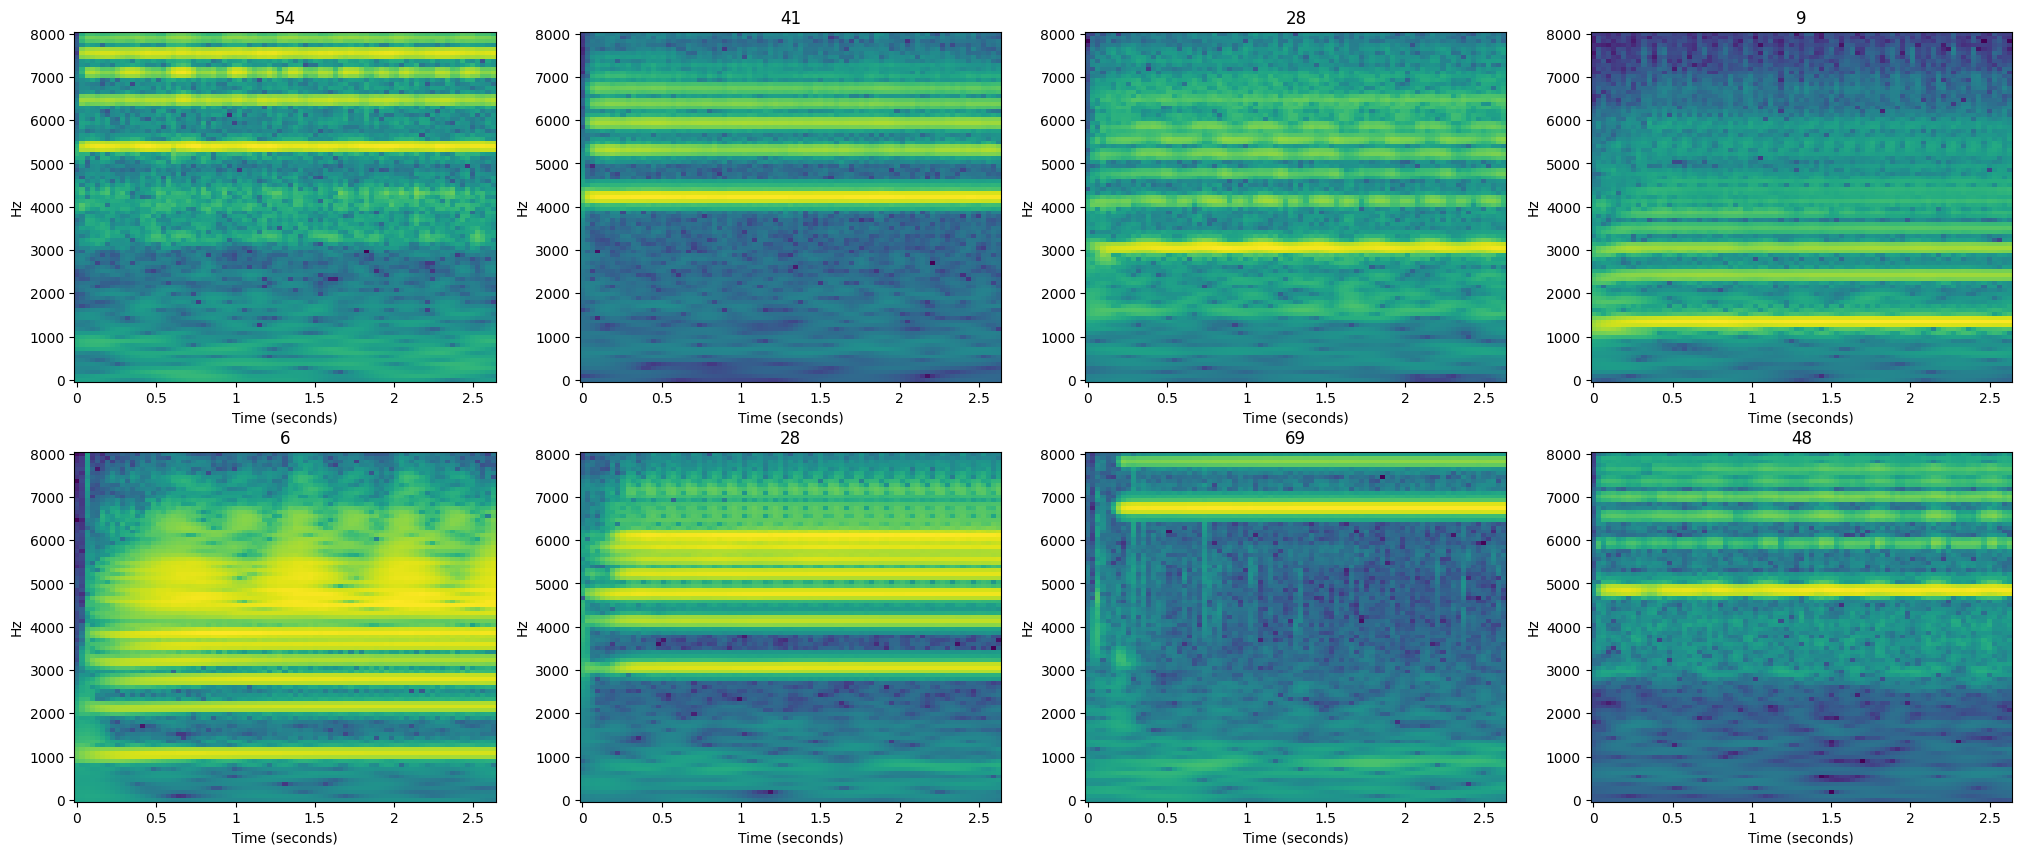

In [ ]:
drawSpec(trainData, trainLabel)

In [ ]:
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')
trainData=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/trainData16_71Class_cqt.npy')
trainLabel=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/trainLabel16_71Class_cqt.npy')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf

class CustomAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,  activation=None):
        super(CustomAttentionLayer, self).__init__()
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):

        self.input_dim = input_shape[-1]
        self.w = self.add_weight(
            shape=(self.input_dim,1),
            initializer="random_normal",
            trainable=True,
        )
        

    def call(self, inputs):        
        
        alphaVector = tf.reshape(self.activation(self.w), shape=[32,])
        # attentionVector = tf.keras.layers.Softmax(axis=0)(alphaVector)
        
        #output = inputs*attentionVector
        
        return alphaVector

input_tensor = tf.keras.layers.Input(shape=(7,6,32), batch_size=None)
layer = CustomAttentionLayer(activation='tanh')(input_tensor)
layer.shape

TensorShape([32])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, Resizing, BatchNormalization, Attention, Activation, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

def buildModel(inputAudio):

  layer1 = Conv2D(32, 3, activation='relu')(inputAudio)  
  layerb = BatchNormalization()(layer1)
  layer2 = MaxPooling2D()(layerb)
  layerd = Dropout(0.25)(layer2)
  layer3 = Conv2D(32, 3, activation='relu')(layerd)  
  layer4 = MaxPooling2D()(layer3)
  layerd1 = Dropout(0.25)(layer4)
  layer5 = Conv2D(32, 3, activation='relu')(layerd1)
  layer6 = MaxPooling2D()(layer5)  
  layerd2 = Dropout(0.25)(layer6)
  layer7 = Conv2D(32, 3, activation='relu')(layerd2)

  attention2D = Conv2D(32, 3, activation=None, padding = 'same')(layer7)
  attentionMap = tf.keras.layers.Softmax()(attention2D)
  multiplyLayer = tf.keras.layers.Multiply()([layer7, attentionMap])

  # alphaLayer = CustomAttentionLayer(activation='tanh')(layer7)
  # attentionLayer = tf.keras.layers.Softmax()(alphaLayer)
  # multiplyLayer = layer7*attentionLayer

  #layer8 = MaxPooling2D()(layer7)  
  layer9 = Dropout(0.25)(multiplyLayer)   
  layer10 = Flatten()(layer9)
  layer11 = Dense(512, activation='relu')(layer10)
  layerd3 = Dropout(0.25)(layer11)  
  layer13 = Dense(128, activation='relu')(layerd3)   
  layerd4 = Dropout(0.25)(layer13)  
  layer14 = Dense(71, activation='softmax')(layerd4) 

  return layer14

numOfRow=90
numOfColumn=83
inputSignal = Input(shape=(numOfRow, numOfColumn, 1), batch_size=128)
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(128, 90, 83, 1)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (128, 88, 81, 32)    320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (128, 88, 81, 32)   128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (128, 44, 40, 32)    0           ['batch_normalization[0][0]']

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_TinySOL_71Class_cqt_attention_Conv2D.h5'
checkpoint = ModelCheckpoint(filepath, monitor='accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#validation=(validationData, validationLabel)
batch_size=32
epochs=30

hist=model.fit( trainData,
                trainLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/30

Epoch 1: accuracy improved from -inf to 0.09732, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_TinySOL_71Class_cqt_attention_Conv2D.h5
76/76 - 15s - loss: 3.6705 - accuracy: 0.0973 - val_loss: 4.1701 - val_accuracy: 0.2168 - 15s/epoch - 195ms/step
Epoch 2/30

Epoch 2: accuracy improved from 0.09732 to 0.64330, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_TinySOL_71Class_cqt_attention_Conv2D.h5
76/76 - 1s - loss: 1.1350 - accuracy: 0.6433 - val_loss: 3.0659 - val_accuracy: 0.8741 - 1s/epoch - 15ms/step
Epoch 3/30

Epoch 3: accuracy improved from 0.64330 to 0.91588, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_TinySOL_71Class_cqt_attention_Conv2D.h5
76/76 - 1s - loss: 0.2670 - accuracy: 0.9159 - val_loss: 1.1226 - val_accuracy: 0.9767 - 1s/epoch - 15ms/step
Epoch 4/30

Epoch 4: accuracy improved from 0.91588 to 0.95052, saving model to /content/gdrive/MyDr